In [7]:
# import librairies and functions needed for project
import os
os.environ["OMP_NUM_THREADS"] = '1' # needed to avoid memory leak warning with K-Means in Windows environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
# from sklearn_extra.cluster import KMedoids 

# import user-defined functions
from functions import *

col = 'red'

# maximise dataframe display
pd.set_option('display.max_colwidth', None)

In [8]:
# Import data & split file
data = pd.read_csv('data_final.csv', encoding='latin_1',index_col=0)
x = data.values
countries = data.index
features = data.columns

1 - 

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assurez-vous d'avoir importé les données
data = pd.read_csv('data_final.csv', encoding='latin_1', index_col=0)

# Standardisation des données
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data)  # Étape manquante ou non exécutée dans votre cas

# Nombre de composantes à utiliser
components = data.shape[1]
pca = PCA(n_components=components)

# Ajustement de l'ACP
pca.fit(x_scaled)

# Résultat : nombre de composantes principales
print("Nombre total de composantes principales :", pca.n_components_)


Nombre total de composantes principales : 11


### Initialisation

### Eboulis des valeurs propres

In [11]:
# create data
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
a_list = range(1, components+1)
list(a_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

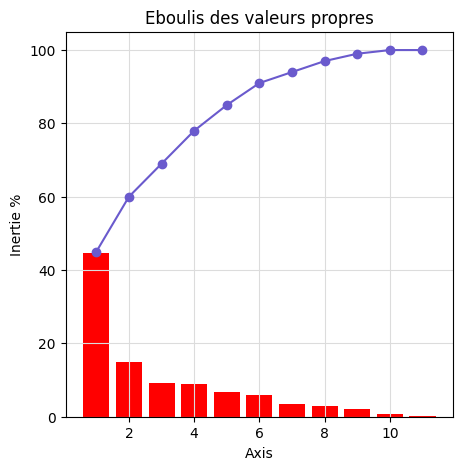

In [19]:
# plot data
plt.figure(figsize=(5,5))
plt.bar(a_list, scree,color=col)
plt.plot(a_list, scree_cum,color='slateblue',marker='o')
plt.xlabel("Axis")
plt.ylabel("Inertie %")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='both', color='gainsboro')
plt.savefig("eboulis.png", bbox_inches='tight')
plt.show(block=False)

#### Nous analyserons plus particulierement les 4 premiers axes, qui permettent de capturer pres de 80% de la variance.

### Analyse des composantes

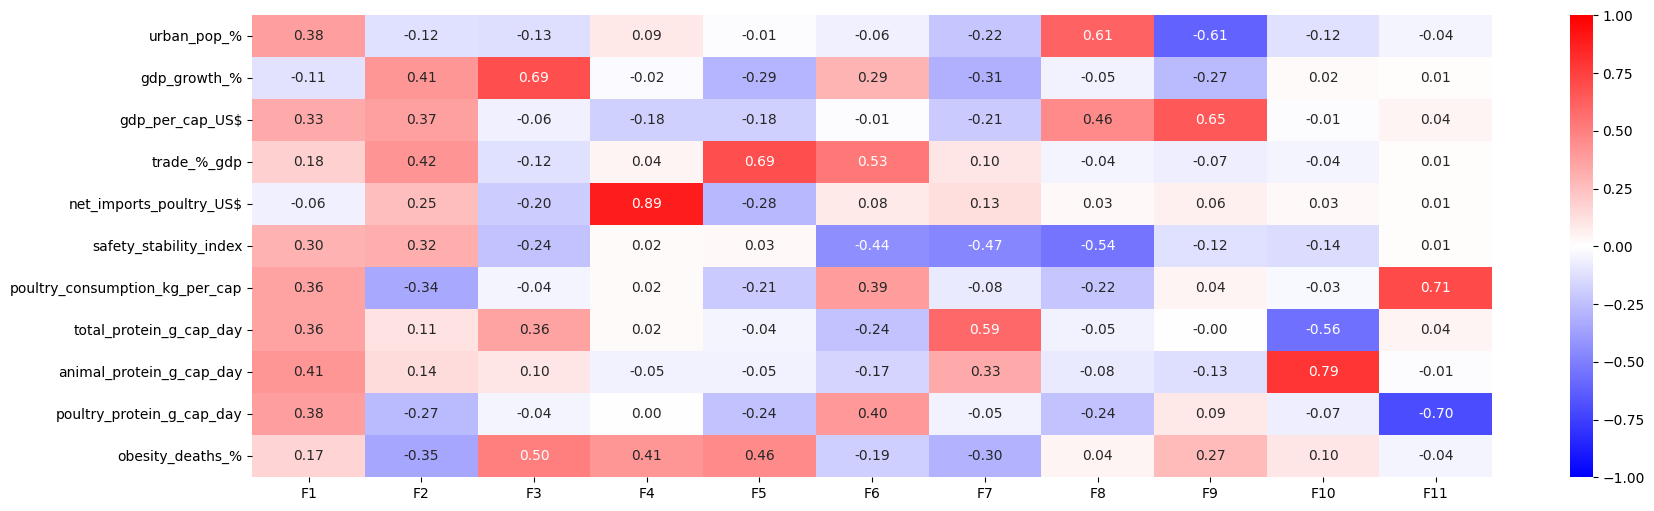

In [13]:
# create components dataframe
acp_components = pd.DataFrame(pca.components_)
acp_components.columns = features
acp_components.index = [f"F{i}" for i in a_list]

# plot heatmap
fig, ax = plt.subplots(figsize=(20, 6))
acp_heatmap = sns.heatmap(acp_components.T.round(2), vmin=-1, vmax=1, annot=True, cmap="bwr", fmt="0.2f")
plt.savefig("acp_heatmap.png")

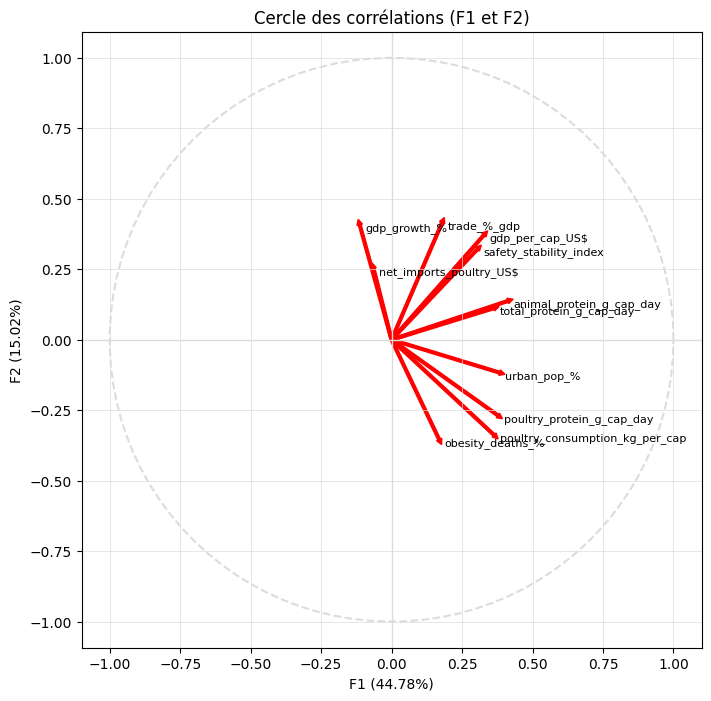

In [14]:
# draw correlation circle for axes 1 and 2
x_y = (0,1)
correlation_graph(pca, x_y, features, col=col)

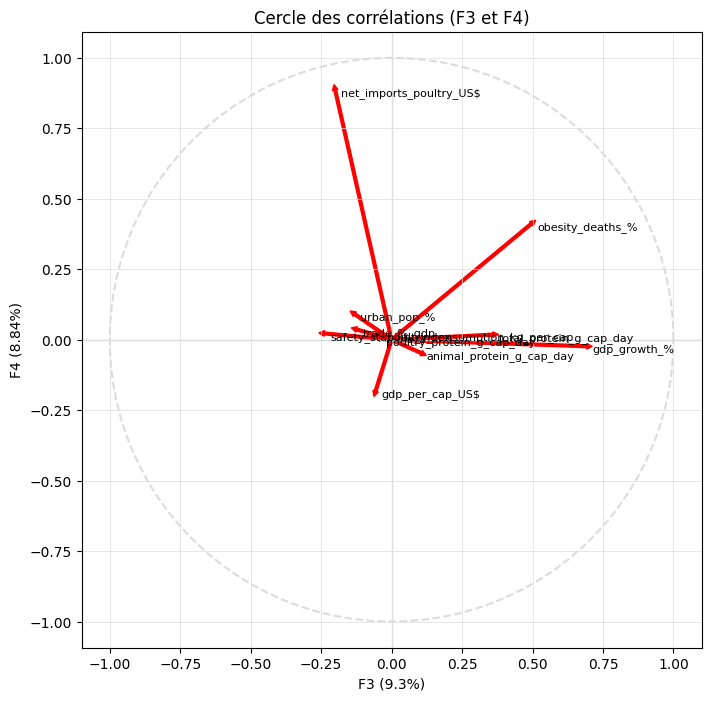

In [15]:
# draw correlation circle for axes 3 and 4
x_y = (2,3)
correlation_graph(pca, x_y, features, col=col)

Réduction des dimensions des données avec ACP

In [34]:
# Transformation des données originales dans le nouvel espace
x_proj = pca.transform(x_scaled)

# Convertir en DataFrame pour manipulation aisée
x_proj_df = pd.DataFrame(x_proj, columns=[f"F{i+1}" for i in range(x_proj.shape[1])])

# 1 - Classification ascendante hierarchique

## 1.1 - Scaling & linkage

In [35]:
std_scale = StandardScaler()
std_scale.fit(x)
x_scaled = std_scale.transform(x)
Z = shc.linkage(x_scaled, method="ward", optimal_ordering=True,
                metric='euclidean') # metric='euclidean' is implied by use of Ward method

## 1.2 - Dendrogramme

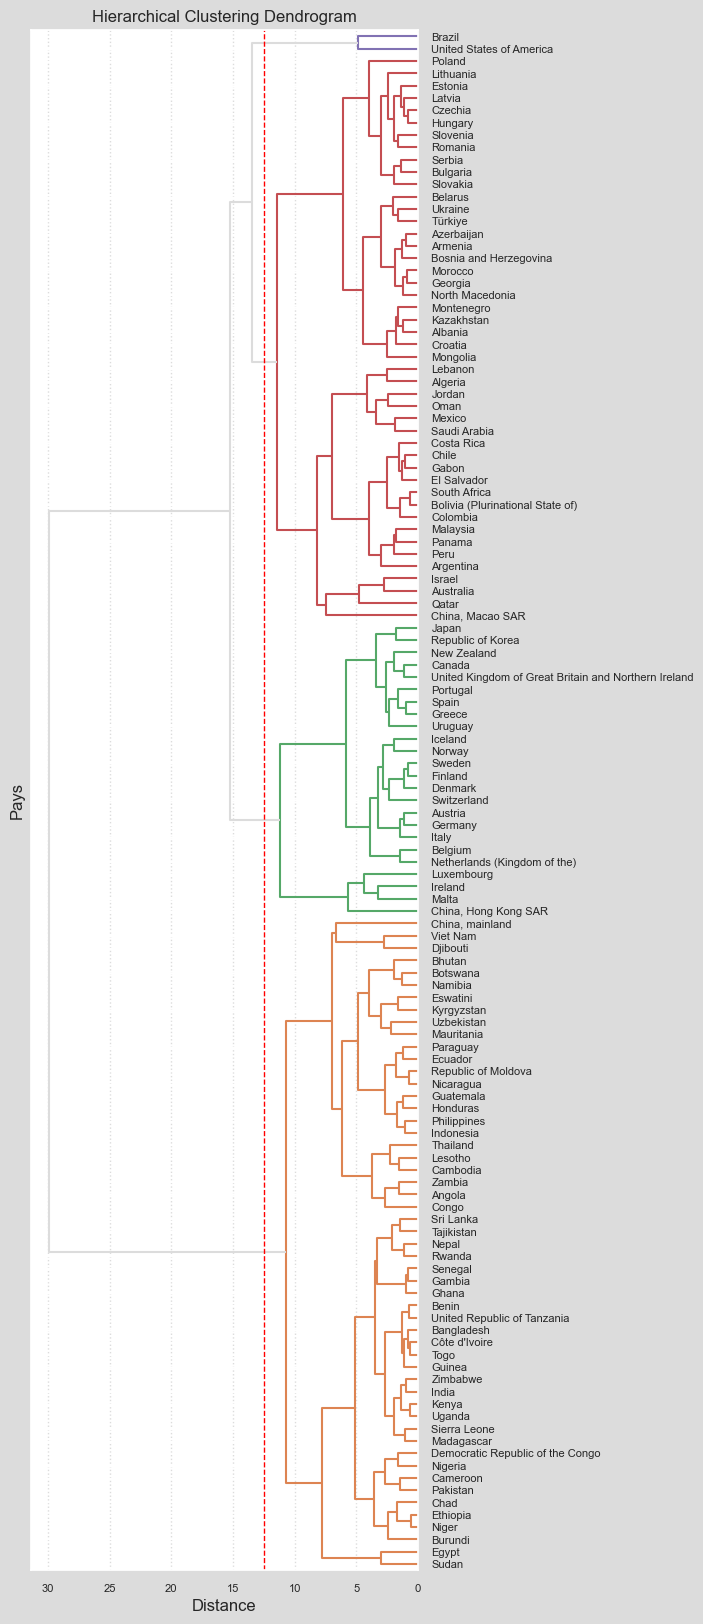

In [36]:
# plot complete vertical dendrogram
limit = 12.5
fig, ax = plt.subplots(1, 1, figsize=(5,20))
detailed_dendro = shc.dendrogram(Z, ax=ax, labels=countries, orientation = "left", color_threshold=limit,
                        leaf_rotation=0, above_threshold_color='gainsboro', leaf_font_size=6)
plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid(axis='x', color='gainsboro', linestyle='dotted')
plt.axvline(x=limit, c=col, lw=1, linestyle='dashed')
plt.savefig("detailed_dendro_v.png", bbox_inches='tight')
plt.show()

#### On pourrait obtenir une analyse plus fine avec 7 clusters en "coupant" le dendrogramme a une distance de 8, mais dans cette premiere etape, nous choisissons de proceder avec 4 clusters qui nous donnent une vision suffisamment detaillee des caracteristiques de nos pays.

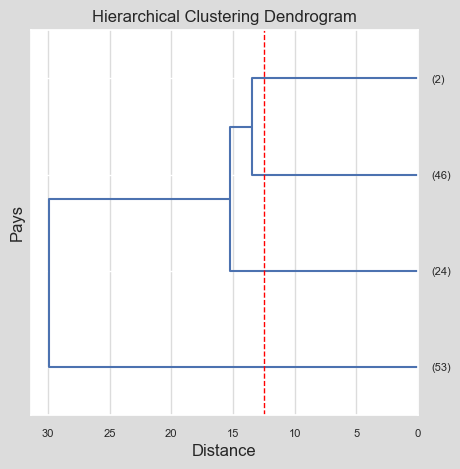

In [37]:
# plot dendrogram with 4 clusters & number of countries in each cluster
nb_clusters_dendro = 4
fig, ax = plt.subplots(1, 1, figsize=(5,5))
dendro_4clust = shc.dendrogram(Z, ax=ax, labels=countries, orientation = "left",
                         truncate_mode = 'lastp', p=nb_clusters_dendro, color_threshold=limit,
                         leaf_font_size=12, leaf_rotation=0)
plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid(axis='x', color='gainsboro')
plt.axvline(x=limit, c=col, lw=1, linestyle='dashed')
plt.savefig("dendro_4clust.png", bbox_inches='tight')
plt.show()

## 1.3 - Affichage des clusters

In [38]:
# print list of countries in each cluster
k = nb_clusters_dendro
dendro_clusters = shc.fcluster(Z, k, criterion='maxclust')
data_clust = pd.DataFrame({"pays" : countries, "cluster_dendro" : dendro_clusters})

for i in range(1, k+1) : 
    # select cluster
    sub_data_clust = data_clust.loc[data_clust['cluster_dendro'] == i]
    # print cluster
    print(f"cluster : {i}")
    # select country
    pays_list = sub_data_clust['pays'].values
    # create list of countries
    txt = [f"{p}" for p in pays_list]
    # add countries to list
    txt = " / ".join(txt)
    # print clusters
    print(txt)
    print("\n\n")

cluster : 1
Angola / Bangladesh / Benin / Bhutan / Botswana / Burundi / Cambodia / Cameroon / Chad / China, mainland / Congo / Côte d'Ivoire / Democratic Republic of the Congo / Djibouti / Ecuador / Egypt / Eswatini / Ethiopia / Gambia / Ghana / Guatemala / Guinea / Honduras / India / Indonesia / Kenya / Kyrgyzstan / Lesotho / Madagascar / Mauritania / Namibia / Nepal / Nicaragua / Niger / Nigeria / Pakistan / Paraguay / Philippines / Republic of Moldova / Rwanda / Senegal / Sierra Leone / Sri Lanka / Sudan / Tajikistan / Thailand / Togo / Uganda / United Republic of Tanzania / Uzbekistan / Viet Nam / Zambia / Zimbabwe



cluster : 2
Austria / Belgium / Canada / China, Hong Kong SAR / Denmark / Finland / Germany / Greece / Iceland / Ireland / Italy / Japan / Luxembourg / Malta / Netherlands (Kingdom of the) / New Zealand / Norway / Portugal / Republic of Korea / Spain / Sweden / Switzerland / United Kingdom of Great Britain and Northern Ireland / Uruguay



cluster : 3
Albania / Algeri

In [39]:
# add cluster info to original data
data_dendro = data.copy().reset_index()
clusters = pd.merge(data_dendro, data_clust, how='left', left_on='country', right_on='pays' ).drop(['pays'], axis=1)

# display clusters mean values
clusters_dendro_avg = clusters.groupby('cluster_dendro').mean(numeric_only=True)
clusters_dendro_avg

urban_pop_%  gdp_growth_%  gdp_per_cap_US$  trade_%_gdp  \
cluster_dendro                                                            
1                  0.431929     -1.670075      2290.833515    65.632717   
2                  0.824950     -2.854008     48357.331209   116.886242   
3                  0.729126     -7.579810     13422.499585    85.375999   
4                  0.844498    -12.253686     34742.659531    27.865212   

                net_imports_poultry_US$  safety_stability_index  \
cluster_dendro                                                    
1                          8.077785e+07               -0.572453   
2                          6.246175e+07                0.860833   
3                         -4.317674e+06               -0.006522   
4                         -4.480669e+09               -0.220000   

                poultry_consumption_kg_per_cap  total_protein_g_cap_day  \
cluster_dendro                                                            
1                                     7.314331                63.006038   
2                                    22.353132                99.135000   
3                                    27.771432                90.241522   
4                                    48.182580               102.000000   

                animal_protein_g_cap_day  poultry_protein_g_cap_day  \
cluster_dendro                                                        
1                              19.652849                   2.474906   
2                              66.422194                   9.103750   
3                              48.883105                   9.730652   
4                              65.346441                  16.255000   

                obesity_deaths_%  
cluster_dendro                    
1                       8.347547  
2                       8.636250  
3                      14.779565  
4                      12.500000

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\331865404.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="gdp_per_cap_US$", hue="cluster_dendro", flierprops={"marker": "1"},


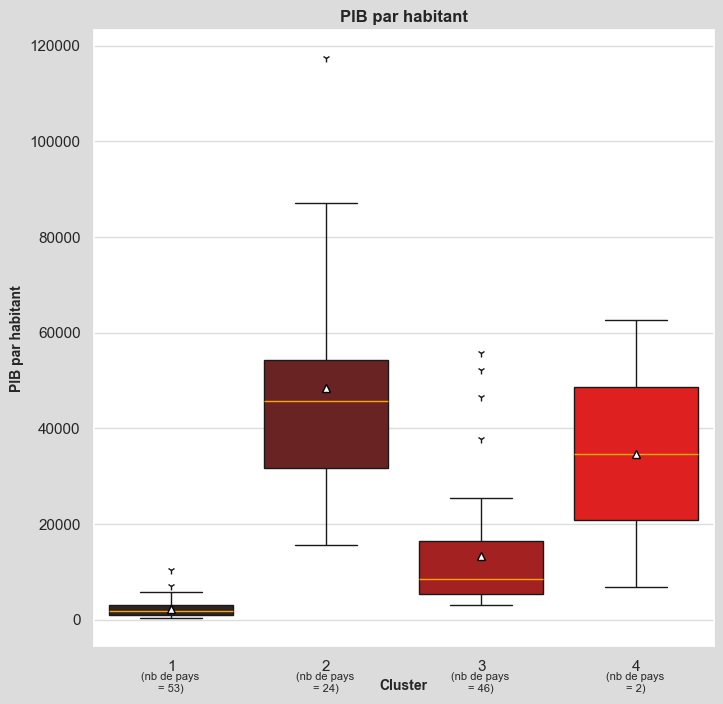

In [40]:
# plot clusters against gdp per capita on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="gdp_per_cap_US$", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('PIB par habitant', fontweight='bold', fontsize=10)
plt.title('PIB par habitant', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, -11000,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -11000,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -11000,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -11000,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_gdp.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\3881377034.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  dendro_box_gdp_growth = sns.boxplot(data=clusters, x="cluster_dendro", y="gdp_growth_%", hue="cluster_dendro", flierprops={"marker": "1"},


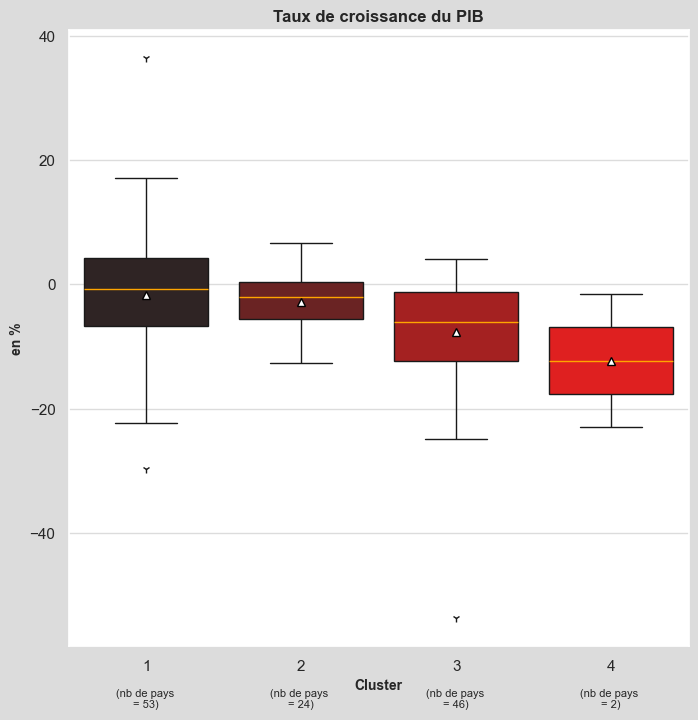

In [41]:
# plot clusters against gdp growth on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp_growth = sns.boxplot(data=clusters, x="cluster_dendro", y="gdp_growth_%", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('en %', fontweight='bold', fontsize=10)
plt.title('Taux de croissance du PIB', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -65,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -65,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -65,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -65,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_gdp_growth.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\977179654.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  dendro_box_trade = sns.boxplot(data=clusters, x="cluster_dendro", y="trade_%_gdp", hue="cluster_dendro", flierprops={"marker": "1"},


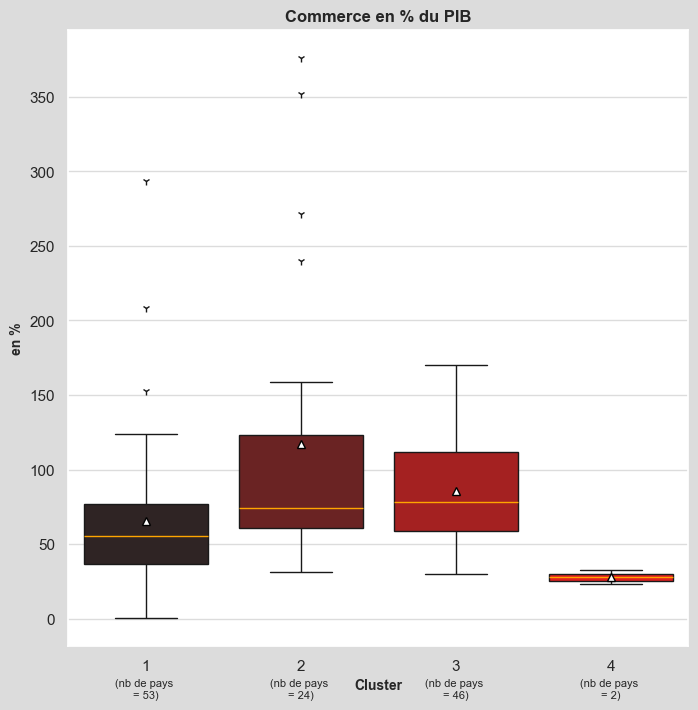

In [42]:
# plot clusters against trade as % gdp on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_trade = sns.boxplot(data=clusters, x="cluster_dendro", y="trade_%_gdp", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('en %', fontweight='bold', fontsize=10)
plt.title('Commerce en % du PIB', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -40,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -40,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -40,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -40,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_trade.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\842700218.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  dendro_box_chicken = sns.boxplot(data=clusters, x="cluster_dendro", y="poultry_consumption_kg_per_cap", hue="cluster_dendro", flierprops={"marker": "1"},


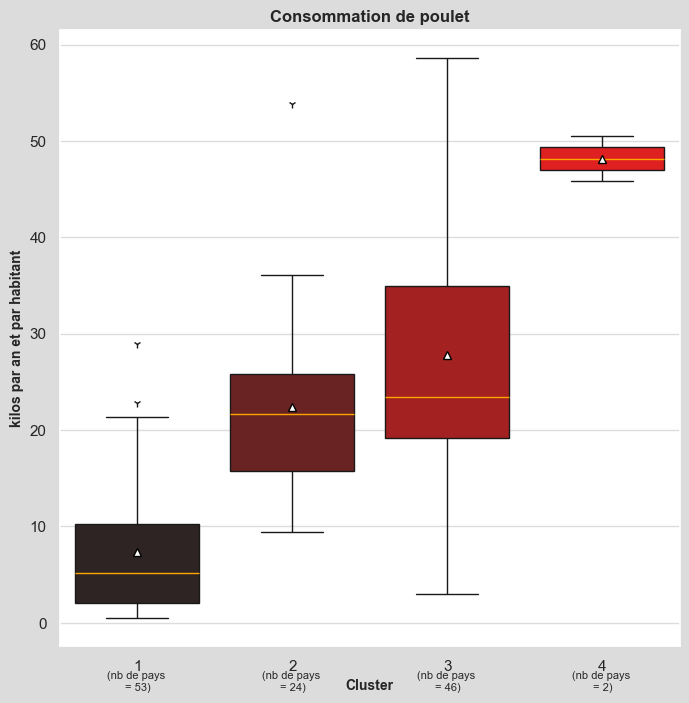

In [43]:
# plot clusters against annual consumption of chicken per capita on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_chicken = sns.boxplot(data=clusters, x="cluster_dendro", y="poultry_consumption_kg_per_cap", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('kilos par an et par habitant', fontweight='bold', fontsize=10)
plt.title('Consommation de poulet', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -5,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -5,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -5,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
        verticalalignment='top', fontsize=8)
plt.text(3, -5,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_chicken.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\2166319126.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  dendro_box_net_M = sns.boxplot(data=clusters, x="cluster_dendro", y="net_imports_poultry_US$", hue="cluster_dendro", flierprops={"marker": "1"},


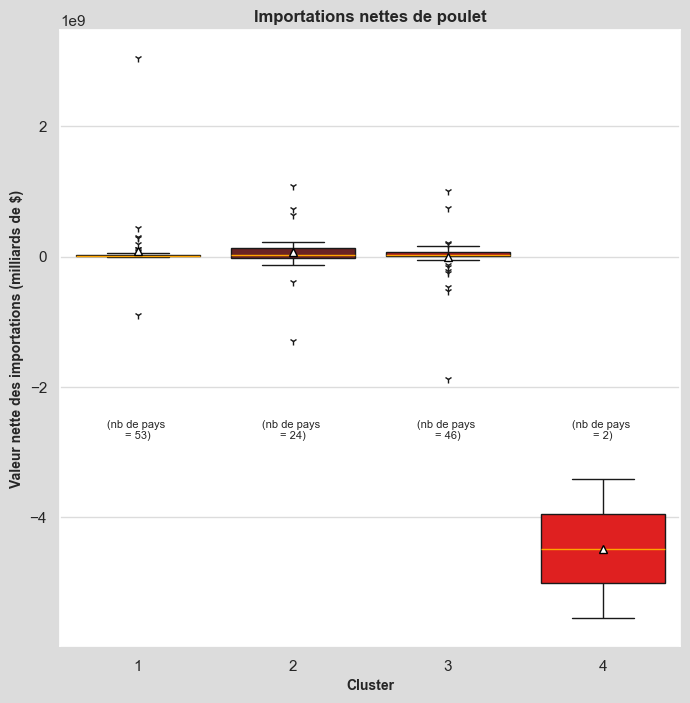

In [44]:
# plot clusters against net poultry imports on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_net_M = sns.boxplot(data=clusters, x="cluster_dendro", y="net_imports_poultry_US$", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel("Valeur nette des importations (milliards de $)", fontweight='bold', fontsize=10)
plt.title('Importations nettes de poulet', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -2500000000,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
        verticalalignment='top', fontsize=8)  
plt.text(1, -2500000000,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -2500000000,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
        verticalalignment='top', fontsize=8)
plt.text(3, -2500000000,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_net_M.png", bbox_inches='tight')
plt.show()

# 2 - K-means clustering

## 2.1 - Centrage & reduction des donnees

In [45]:
# center & reduce data
x = data.copy()
std_scaler = StandardScaler()
std_scaler.fit(x)
x_scaled = std_scaler.transform(x)

## 2.2 - Determination du nombre optimal de clusters

### Methode du coude

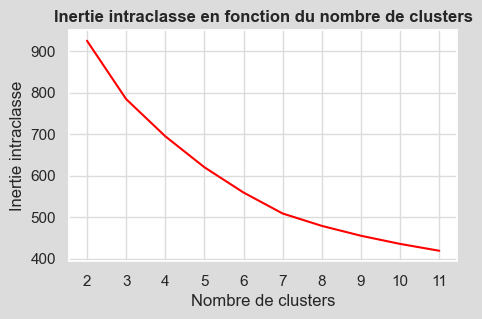

In [46]:
# Test for number of clusters between 2 and number of columns in data (=11)
k_list = range(2, data.shape[1]+1)

# Create data for within-cluster sum of squares for K-means clusters between 2 and 11
wcss = []

for i in k_list:
    kmeans_wcss = KMeans(n_clusters=i, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
    kmeans_wcss.fit(x_scaled)
    wcss.append(kmeans_wcss.inertia_)

# Plot wcss curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel("Inertie intraclasse")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Inertie intraclasse en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, wcss, color=col)
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("kmeans_coude.png", bbox_inches='tight')
plt.show()

#### La courbe ne comporte pas de "coude" evident.

### Silhouette score

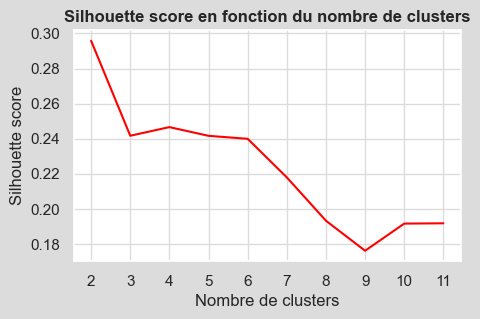

In [47]:
# Calculate score for number of K-means clusters between 2 and 11
silhouette = []

for j in k_list:
    kmeans_silh = KMeans(n_clusters=j, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
    kmeans_silh.fit(x_scaled)
    silh = silhouette_score(x_scaled, kmeans_silh.labels_)
    silhouette.append(silh)

# Plot silhouette score curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel("Silhouette score")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Silhouette score en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, silhouette, color=col)
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("silhouette.png", bbox_inches='tight')
plt.show()

#### Le score silhouette est maximal avec 2 clusters mais semble indiquer 4 ou 6 clusters comme acceptables.

### Indice de Davies-Bouldin

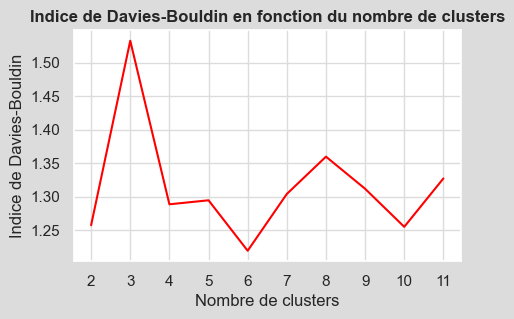

In [48]:
# Calculate score for number of K-means clusters between 2 and 11
dav_bould = []

for h in k_list:
    kmeans_db = KMeans(n_clusters=h, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
    kmeans_db.fit(x_scaled)
    d_b = davies_bouldin_score(x_scaled, kmeans_db.labels_)
    dav_bould.append(d_b)

# Plot Davies-Bouldin score curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel("Indice de Davies-Bouldin")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Indice de Davies-Bouldin en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, dav_bould, color=col)
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("davies_bouldin.png", bbox_inches='tight')
plt.show()

#### Le score de Davies-Bouldin est maximal pour 3 clusters et similaire pour 4 ou 5 clusters.
#### Nous procederons donc au clustering sur 4, 5 et 6 clusters afin de comparer les resultats et de decider du nombre de clusters a conserver en fonction de l'ampleur des differences observees.

## 2.3 - K-means clustering sur 4, 5 et 6 clusters

### K-means sur 6 clusters

In [49]:
# Run K-means
kmeans_6 = KMeans(n_clusters=6, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
kmeans_6.fit(x_scaled)
labels_6 = kmeans_6.labels_

# Add cluster number to each country in clusters dataframe
clusters['cluster_km_6'] = (kmeans_6.labels_ + 1)

# Print list of countries in each cluster
cluster_6_1 = clusters.loc[clusters['cluster_km_6'] == 1]['country'].tolist()
print('Pays du 1er cluster - ', len(cluster_6_1),'pays:\n', cluster_6_1)
cluster_6_2 = clusters.loc[clusters['cluster_km_6'] == 2]['country'].tolist()
print('Pays du 2eme cluster - ', len(cluster_6_2),'pays:\n', cluster_6_2)
cluster_6_3 = clusters.loc[clusters['cluster_km_6'] == 3]['country'].tolist()
print('Pays du 3eme cluster - ', len(cluster_6_3),'pays:\n', cluster_6_3)
cluster_6_4 = clusters.loc[clusters['cluster_km_6'] == 4]['country'].tolist()
print('Pays du 4eme cluster - ', len(cluster_6_4),'pays:\n', cluster_6_4)
cluster_6_5 = clusters.loc[clusters['cluster_km_6'] == 5]['country'].tolist()
print('Pays du 5eme cluster - ', len(cluster_6_5),'pays:\n', cluster_6_5)
cluster_6_6 = clusters.loc[clusters['cluster_km_6'] == 6]['country'].tolist()
print('Pays du 6eme cluster - ', len(cluster_6_6),'pays:\n', cluster_6_6)

Pays du 1er cluster -  22 pays:
 ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'Germany', 'Greece', 'Iceland', 'Italy', 'Japan', 'Lithuania', 'Netherlands (Kingdom of the)', 'New Zealand', 'Norway', 'Portugal', 'Republic of Korea', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom of Great Britain and Northern Ireland', 'Uruguay']
Pays du 2eme cluster -  43 pays:
 ['Angola', 'Bangladesh', 'Benin', 'Bhutan', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', 'Congo', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti', 'Eswatini', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'Honduras', 'India', 'Indonesia', 'Kenya', 'Lesotho', 'Madagascar', 'Mauritania', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Philippines', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sri Lanka', 'Sudan', 'Tajikistan', 'Thailand', 'Togo', 'Uganda', 'United Republic of Tanzania', 'Viet Nam', 'Zambia', 'Zimbabwe']
Pays du 3eme cluster -  16 pays:
 ['Argentina', 'Bolivia (Plurinational State of

### K-means sur 5 clusters

In [50]:
# Run K-means
kmeans_5 = KMeans(n_clusters=5, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
kmeans_5.fit(x_scaled)
labels_5 = kmeans_5.labels_

# Add cluster number to each country in clusters dataframe
clusters['cluster_km_5'] = (kmeans_5.labels_ + 1)

# Print list of countries in each cluster
cluster_5_1 = clusters.loc[clusters['cluster_km_5'] == 1]['country'].tolist()
print('Pays du 1er cluster - ', len(cluster_5_1),'pays:\n', cluster_5_1)
cluster_5_2 = clusters.loc[clusters['cluster_km_5'] == 2]['country'].tolist()
print('Pays du 2eme cluster - ', len(cluster_5_2),'pays:\n', cluster_5_2)
cluster_5_3 = clusters.loc[clusters['cluster_km_5'] == 3]['country'].tolist()
print('Pays du 3eme cluster - ', len(cluster_5_3),'pays:\n', cluster_5_3)
cluster_5_4 = clusters.loc[clusters['cluster_km_5'] == 4]['country'].tolist()
print('Pays du 4eme cluster - ', len(cluster_5_4),'pays:\n', cluster_5_4)
cluster_5_5 = clusters.loc[clusters['cluster_km_5'] == 5]['country'].tolist()
print('Pays du 5eme cluster - ', len(cluster_5_5),'pays:\n', cluster_5_5)

Pays du 1er cluster -  22 pays:
 ['Australia', 'Austria', 'Belgium', 'Canada', 'China, Hong Kong SAR', 'Denmark', 'Finland', 'Germany', 'Iceland', 'Ireland', 'Japan', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands (Kingdom of the)', 'New Zealand', 'Norway', 'Portugal', 'Republic of Korea', 'Sweden', 'Switzerland', 'United Kingdom of Great Britain and Northern Ireland']
Pays du 2eme cluster -  39 pays:
 ['Albania', 'Algeria', 'Armenia', 'Azerbaijan', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 'Bulgaria', 'China, mainland', 'Croatia', 'Czechia', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Georgia', 'Guatemala', 'Hungary', 'Italy', 'Jordan', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nicaragua', 'North Macedonia', 'Paraguay', 'Poland', 'Republic of Moldova', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Türkiye', 'Ukraine', 'Uzbekistan']
Pays du 3eme cluster -  41 pays:
 ['Angola', 'Bangladesh', 'Benin', 'Burundi', 'Cambodia', 'Cameroo

### K-means sur 4 clusters

In [51]:
# Run K-means
kmeans_4 = KMeans(n_clusters=nb_clusters_dendro, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
kmeans_4.fit(x_scaled)
labels_4 = kmeans_4.labels_

# Add cluster number to each country in clusters dataframe
clusters['cluster_km_4'] = (kmeans_4.labels_ + 1)

# Print list of countries in each cluster
cluster_4_1 = clusters.loc[clusters['cluster_km_4'] == 1]['country'].tolist()
print('Pays du 1er cluster - ', len(cluster_4_1),'pays:\n', cluster_4_1)
cluster_4_2 = clusters.loc[clusters['cluster_km_4'] == 2]['country'].tolist()
print('Pays du 2eme cluster - ', len(cluster_4_2),'pays:\n', cluster_4_2)
cluster_4_3 = clusters.loc[clusters['cluster_km_4'] == 3]['country'].tolist()
print('Pays du 3eme cluster - ', len(cluster_4_3),'pays:\n', cluster_4_3)
cluster_4_4 = clusters.loc[clusters['cluster_km_4'] == 4]['country'].tolist()
print('Pays du 4eme cluster - ', len(cluster_4_4),'pays:\n', cluster_4_4)

Pays du 1er cluster -  42 pays:
 ['Angola', 'Bangladesh', 'Benin', 'Bhutan', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti', 'Eswatini', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'India', 'Indonesia', 'Kenya', 'Kyrgyzstan', 'Lesotho', 'Madagascar', 'Mauritania', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Philippines', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sri Lanka', 'Sudan', 'Tajikistan', 'Thailand', 'Togo', 'Uganda', 'United Republic of Tanzania', 'Viet Nam', 'Zambia', 'Zimbabwe']
Pays du 2eme cluster -  35 pays:
 ['Argentina', 'Australia', 'Austria', 'Belgium', 'Canada', 'China, Hong Kong SAR', 'China, Macao SAR', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Luxembourg', 'Malta', 'Mongolia', 'Netherlands (Kingdom of the)', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Qatar', 'Republic of Korea', 'Slovenia', 'Spain', 'Sweden', 'Sw

#### Avec 4, 5 ou 6 clusters, le Bresil et les USA appartiennent a un cluster separe du fait de leurs statut de grand exportateur net de poulet. Ce resultat s'observe egalement sur le haut du dendrogramme.
#### Dans le K-means a 6 clusters, 'China, Hong Kong SAR', 'Ireland', 'Luxembourg' et 'Malta' sont separes du cluster qui contient les autres pays europeens. Leur statut de hub financier leur confere un PIB par habitant singulier mais qui ne justifie pas une analyse dans un cluster separe pour nos besoins.
#### Les clusters produits par la CAH et le K-means sont tres proches mais neanmoins pas identiques : leur ordre et leur composition sont differentes, et ce resultat est normal, les deux methodes n'aboutissant generalement pas a des resultats identiques. Cependant, si on se refere aux differents boxplots, on constate que les caracteristiques generiques des groupes constitues en termes de PIB par habitant, consommation de volaille, importations nettes etc... sont dans l'ensemble conservees.
#### Nous choisissons donc d'analyser nos donnees selon 4 clusters, afin de les comparer plus facilement aux resultats de la CAH. Analysons leurs caracteristiques:

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\3876202657.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  km_4_box_gdp = sns.boxplot(data=clusters, x="cluster_km_4", y="gdp_per_cap_US$", hue="cluster_km_4", flierprops={"marker": "1"},


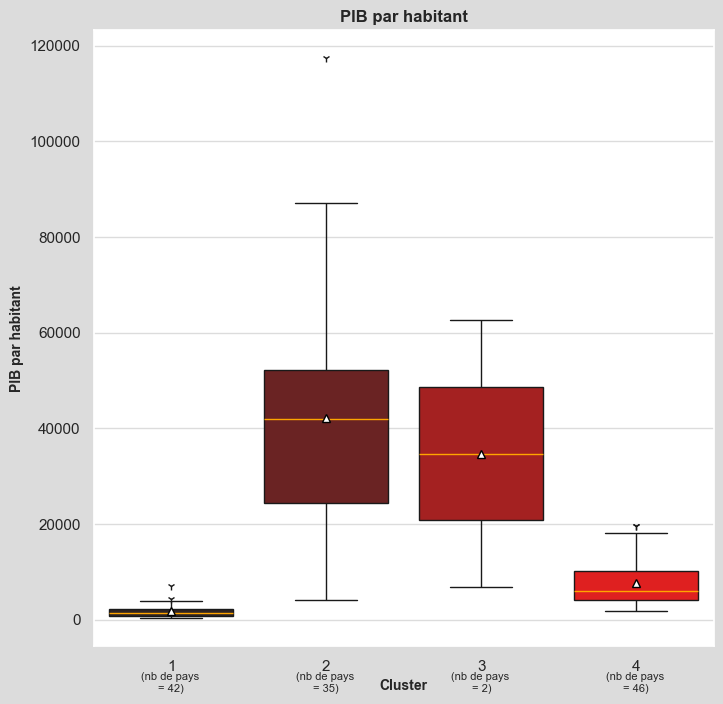

In [52]:
# plot clusters against gdp per capita on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
km_4_box_gdp = sns.boxplot(data=clusters, x="cluster_km_4", y="gdp_per_cap_US$", hue="cluster_km_4", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('PIB par habitant', fontweight='bold', fontsize=10)
plt.title('PIB par habitant', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
nb_pays_2 = clusters.groupby('cluster_km_4')['country'].count().reset_index()
plt.text(0, -11000,"(nb de pays \n= {})".format(nb_pays_2.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -11000,"(nb de pays \n= {})".format(nb_pays_2.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -11000,"(nb de pays \n= {})".format(nb_pays_2.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -11000,"(nb de pays \n= {})".format(nb_pays_2.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("km_4_box_gdp.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\1802468227.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  km_4_box_gdp_growth = sns.boxplot(data=clusters, x="cluster_km_4", y="gdp_growth_%", hue="cluster_km_4", flierprops={"marker": "1"},


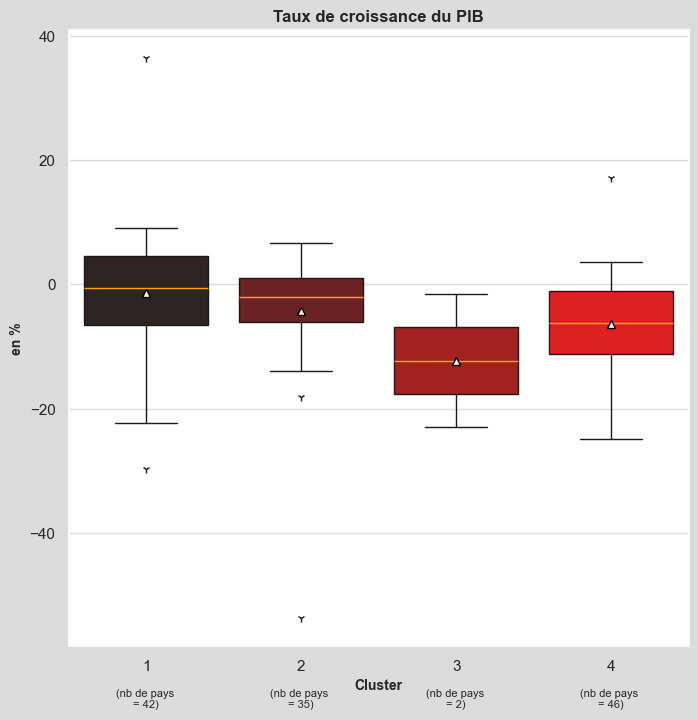

In [53]:
# plot clusters against gdp growth on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
km_4_box_gdp_growth = sns.boxplot(data=clusters, x="cluster_km_4", y="gdp_growth_%", hue="cluster_km_4", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('en %', fontweight='bold', fontsize=10)
plt.title('Taux de croissance du PIB', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -65,"(nb de pays \n= {})".format(nb_pays_2.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -65,"(nb de pays \n= {})".format(nb_pays_2.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -65,"(nb de pays \n= {})".format(nb_pays_2.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -65,"(nb de pays \n= {})".format(nb_pays_2.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("km_4_box_gdp_growth.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\2879136834.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  km_4_box_trade = sns.boxplot(data=clusters, x="cluster_km_4", y="trade_%_gdp", hue="cluster_km_4", flierprops={"marker": "1"},


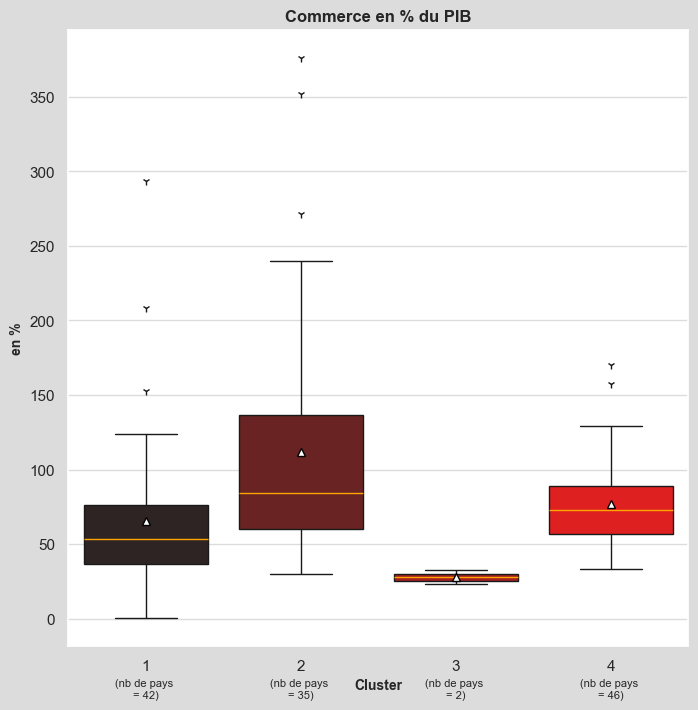

In [54]:
# plot clusters against trade as % gdp on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
km_4_box_trade = sns.boxplot(data=clusters, x="cluster_km_4", y="trade_%_gdp", hue="cluster_km_4", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('en %', fontweight='bold', fontsize=10)
plt.title('Commerce en % du PIB', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -40,"(nb de pays \n= {})".format(nb_pays_2.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -40,"(nb de pays \n= {})".format(nb_pays_2.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -40,"(nb de pays \n= {})".format(nb_pays_2.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -40,"(nb de pays \n= {})".format(nb_pays_2.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("km_4_box_trade.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\3558627889.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  km_4_box_chicken = sns.boxplot(data=clusters, x="cluster_km_4", y="poultry_consumption_kg_per_cap", hue="cluster_km_4", flierprops={"marker": "1"},


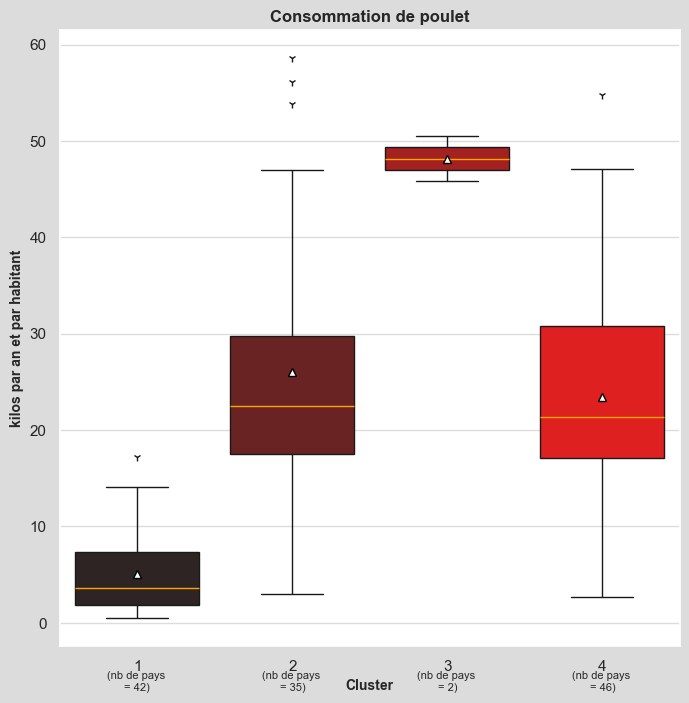

In [55]:
# plot clusters against annual consumption of chicken per capita on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
km_4_box_chicken = sns.boxplot(data=clusters, x="cluster_km_4", y="poultry_consumption_kg_per_cap", hue="cluster_km_4", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('kilos par an et par habitant', fontweight='bold', fontsize=10)
plt.title('Consommation de poulet', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
plt.text(0, -5,"(nb de pays \n= {})".format(nb_pays_2.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -5,"(nb de pays \n= {})".format(nb_pays_2.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -5,"(nb de pays \n= {})".format(nb_pays_2.iloc[2, 1]), horizontalalignment='center',
        verticalalignment='top', fontsize=8)
plt.text(3, -5,"(nb de pays \n= {})".format(nb_pays_2.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("km_4_box_chicken.png", bbox_inches='tight')
plt.show()

C:\Users\jemko\AppData\Local\Temp\ipykernel_13092\2932936846.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  km_4_box_net_M = sns.boxplot(data=clusters, x="cluster_km_4", y="net_imports_poultry_US$", hue="cluster_km_4", flierprops={"marker": "1"},


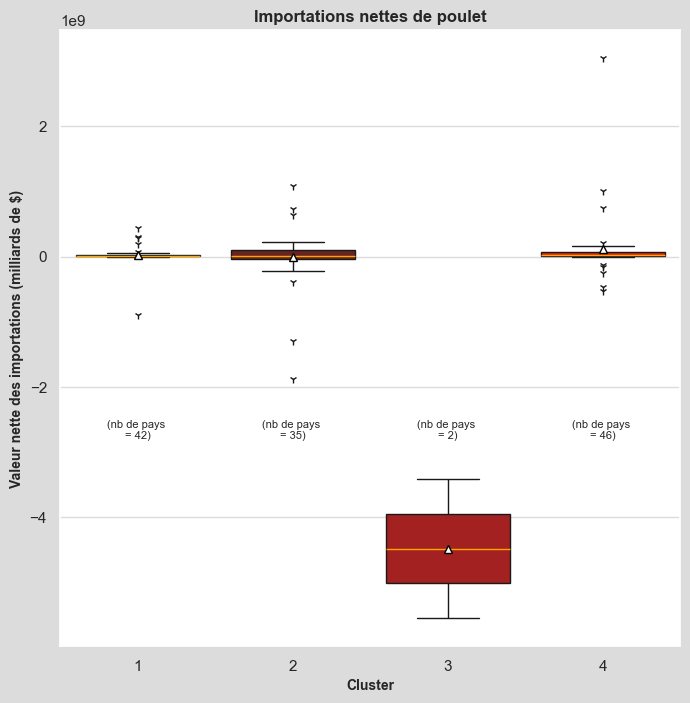

In [56]:
# plot clusters against net poultry imports on a box plot
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
km_4_box_net_M = sns.boxplot(data=clusters, x="cluster_km_4", y="net_imports_poultry_US$", hue="cluster_km_4", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", color=col, showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel("Valeur nette des importations (milliards de $)", fontweight='bold', fontsize=10)
plt.title('Importations nettes de poulet', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
# nb_pays = clusters.groupby('cluster')['country'].count().reset_index()
plt.text(0, -2500000000,"(nb de pays \n= {})".format(nb_pays_2.iloc[0, 1]), horizontalalignment='center',
        verticalalignment='top', fontsize=8)  
plt.text(1, -2500000000,"(nb de pays \n= {})".format(nb_pays_2.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -2500000000,"(nb de pays \n= {})".format(nb_pays_2.iloc[2, 1]), horizontalalignment='center',
        verticalalignment='top', fontsize=8)
plt.text(3, -2500000000,"(nb de pays \n= {})".format(nb_pays_2.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("km_4_box_net_M.png", bbox_inches='tight')
plt.show()

### Analyse des centroides

In [57]:
centroids_4 = kmeans_4.cluster_centers_
centroids_km_4 = pd.DataFrame(centroids_4)
centroids_km_4.columns = features
centroids_km_4

urban_pop_%  gdp_growth_%  gdp_per_cap_US$  trade_%_gdp  \
0    -1.074955      0.297664        -0.651113    -0.278256   
1     0.876428     -0.012223         1.227886     0.508637   
2     1.032328     -0.839809         0.884872    -0.922642   
3     0.269750     -0.225967        -0.378239    -0.092832   

   net_imports_poultry_US$  safety_stability_index  \
0                 0.064800               -0.693495   
1                 0.027618                1.058001   
2                -6.276590               -0.168504   
3                 0.192716               -0.164483   

   poultry_consumption_kg_per_cap  total_protein_g_cap_day  \
0                       -0.950520                -0.967703   
1                        0.545784                 0.951006   
2                        2.127910                 1.035189   
3                        0.360078                 0.114955   

   animal_protein_g_cap_day  poultry_protein_g_cap_day  obesity_deaths_%  
0                 -1.032526                  -0.945895         -0.819707  
1                  1.172484                   0.671118         -0.148859  
2                  1.124948                   1.870540          0.363508  
3                  0.001723                   0.271682          0.845886

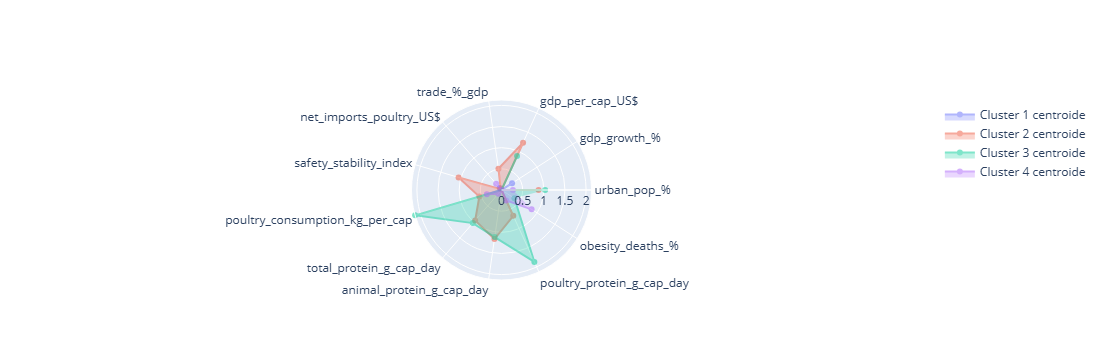

In [58]:
# plot polar chart centroids
categories = centroids_km_4.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_4.iloc[3], theta=categories, fill='toself', name='Cluster 4 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, centroids_km_4.max().max()])),showlegend=True)
# fig.write_image("centroids_radar.png")
fig.show()

## 2.4 - K-medoids clustering sur 4 clusters

In [59]:
from sklearn.cluster import KMeans

# Spécification de l'algorithme valide ('lloyd' ou 'elkan')
kmeans_4 = KMeans(n_clusters=nb_clusters_dendro, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)

# Appliquez KMeans
kmeans_4.fit(x_scaled)

# Récupérez les labels des clusters
labels_4 = kmeans_4.labels_

# Ajoutez les labels au DataFrame
clusters['cluster_km_4'] = (kmeans_4.labels_ + 1)

# Affichez les pays dans chaque cluster
cluster_4_1 = clusters.loc[clusters['cluster_km_4'] == 1]['country'].tolist()
print('Pays du 1er cluster - ', len(cluster_4_1),'pays:\n', cluster_4_1)
cluster_4_2 = clusters.loc[clusters['cluster_km_4'] == 2]['country'].tolist()
print('Pays du 2eme cluster - ', len(cluster_4_2),'pays:\n', cluster_4_2)
cluster_4_3 = clusters.loc[clusters['cluster_km_4'] == 3]['country'].tolist()
print('Pays du 3eme cluster - ', len(cluster_4_3),'pays:\n', cluster_4_3)
cluster_4_4 = clusters.loc[clusters['cluster_km_4'] == 4]['country'].tolist()
print('Pays du 4eme cluster - ', len(cluster_4_4),'pays:\n', cluster_4_4)

Pays du 1er cluster -  34 pays:
 ['Argentina', 'Australia', 'Austria', 'Belgium', 'Canada', 'China, Hong Kong SAR', 'China, Macao SAR', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands (Kingdom of the)', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Qatar', 'Republic of Korea', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom of Great Britain and Northern Ireland', 'Uruguay']
Pays du 2eme cluster -  42 pays:
 ['Angola', 'Bangladesh', 'Benin', 'Bhutan', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti', 'Eswatini', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'India', 'Indonesia', 'Kenya', 'Kyrgyzstan', 'Lesotho', 'Madagascar', 'Mauritania', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Philippines', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sri Lanka', 'Sudan', 'Tajikistan', 'Thailand', 'Togo', 'Uganda'

### Analyse des medoides

In [60]:
from sklearn.cluster import KMeans

# Spécification de l'algorithme valide ('lloyd' ou 'elkan')
kmeans_4 = KMeans(n_clusters=nb_clusters_dendro, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)

# Appliquez KMeans
kmeans_4.fit(x_scaled)

# Récupérez les labels des clusters
labels_4 = kmeans_4.labels_

# Ajoutez les labels au DataFrame
clusters['cluster_km_4'] = (kmeans_4.labels_ + 1)

# Affichez les pays dans chaque cluster
cluster_4_1 = clusters.loc[clusters['cluster_km_4'] == 1]['country'].tolist()
print('Pays du 1er cluster - ', len(cluster_4_1),'pays:\n', cluster_4_1)
cluster_4_2 = clusters.loc[clusters['cluster_km_4'] == 2]['country'].tolist()
print('Pays du 2eme cluster - ', len(cluster_4_2),'pays:\n', cluster_4_2)
cluster_4_3 = clusters.loc[clusters['cluster_km_4'] == 3]['country'].tolist()
print('Pays du 3eme cluster - ', len(cluster_4_3),'pays:\n', cluster_4_3)
cluster_4_4 = clusters.loc[clusters['cluster_km_4'] == 4]['country'].tolist()
print('Pays du 4eme cluster - ', len(cluster_4_4),'pays:\n', cluster_4_4)

Pays du 1er cluster -  40 pays:
 ['Angola', 'Bangladesh', 'Benin', 'Bhutan', 'Burundi', 'Cambodia', 'Cameroon', 'Chad', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Djibouti', 'Eswatini', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'India', 'Indonesia', 'Kenya', 'Lesotho', 'Madagascar', 'Mauritania', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Philippines', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sri Lanka', 'Sudan', 'Tajikistan', 'Thailand', 'Togo', 'Uganda', 'United Republic of Tanzania', 'Viet Nam', 'Zambia', 'Zimbabwe']
Pays du 2eme cluster -  45 pays:
 ['Albania', 'Algeria', 'Armenia', 'Azerbaijan', 'Belarus', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Bulgaria', 'Chile', 'China, mainland', 'Colombia', 'Congo', 'Croatia', 'Ecuador', 'Egypt', 'El Salvador', 'Gabon', 'Georgia', 'Guatemala', 'Honduras', 'Hungary', 'Jordan', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nicaragua', 'North M

              urban_pop_%  gdp_growth_%  gdp_per_cap_US$  trade_%_gdp  \
cluster_km_4                                                            
1                0.381999     -0.207358      1337.766687    52.253540   
2                0.667717     -6.288575      5645.199290    76.405991   
3                0.818817     -2.358082     40286.782148    78.642612   
4                0.844498    -12.253686     34742.659531    27.865212   

              net_imports_poultry_US$  safety_stability_index  \
cluster_km_4                                                    
1                        4.551500e+06                   -0.57   
2                        2.939800e+07                   -0.33   
3                        1.348300e+07                    0.85   
4                       -4.480669e+09                   -0.22   

              poultry_consumption_kg_per_cap  total_protein_g_cap_day  \
cluster_km_4                                                            
1                       

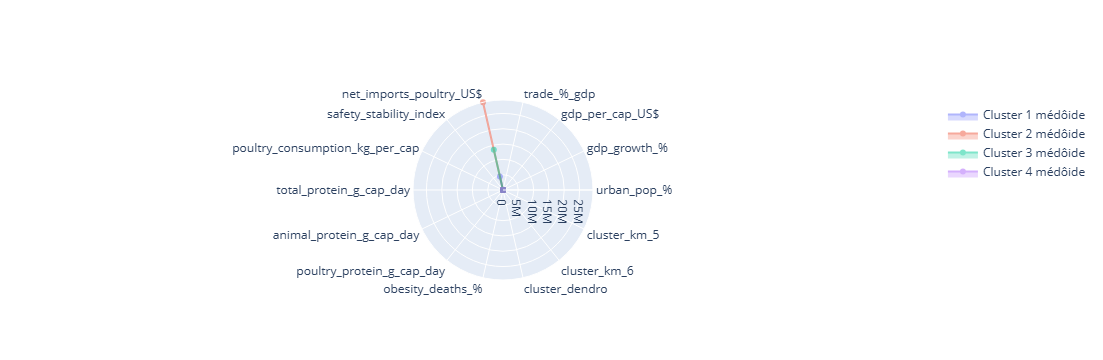

In [61]:
import pandas as pd
import plotly.graph_objects as go

# Exemple de données pour illustrer
# clusters = pd.read_csv("votre_fichier.csv")  # Chargez vos données ici

# Filtrer les colonnes numériques
numeric_columns = clusters.select_dtypes(include=['number']).columns

# Calculer les médianes des clusters uniquement sur les colonnes numériques
medoids_kmed_4 = clusters[numeric_columns].groupby('cluster_km_4').median()

# Vérifier les médianes calculées
print(medoids_kmed_4)

# Si vous n'avez pas encore calculé les médianes, voici comment les visualiser sur un graphique polaire
categories2 = medoids_kmed_4.columns

# Création de la figure pour le graphique polaire
fig2 = go.Figure()

# Ajouter les traces pour chaque cluster
fig2.add_trace(go.Scatterpolar(r=medoids_kmed_4.iloc[0], theta=categories2, fill='toself', name='Cluster 1 médôide'))
fig2.add_trace(go.Scatterpolar(r=medoids_kmed_4.iloc[1], theta=categories2, fill='toself', name='Cluster 2 médôide'))
fig2.add_trace(go.Scatterpolar(r=medoids_kmed_4.iloc[2], theta=categories2, fill='toself', name='Cluster 3 médôide'))
fig2.add_trace(go.Scatterpolar(r=medoids_kmed_4.iloc[3], theta=categories2, fill='toself', name='Cluster 4 médôide'))

# Mettre à jour les traces
fig2.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))

# Mettre à jour la mise en page avec l'axe radial
fig2.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, medoids_kmed_4.max().max()])
    ),
    showlegend=True
)

# Afficher le graphique
fig2.show()

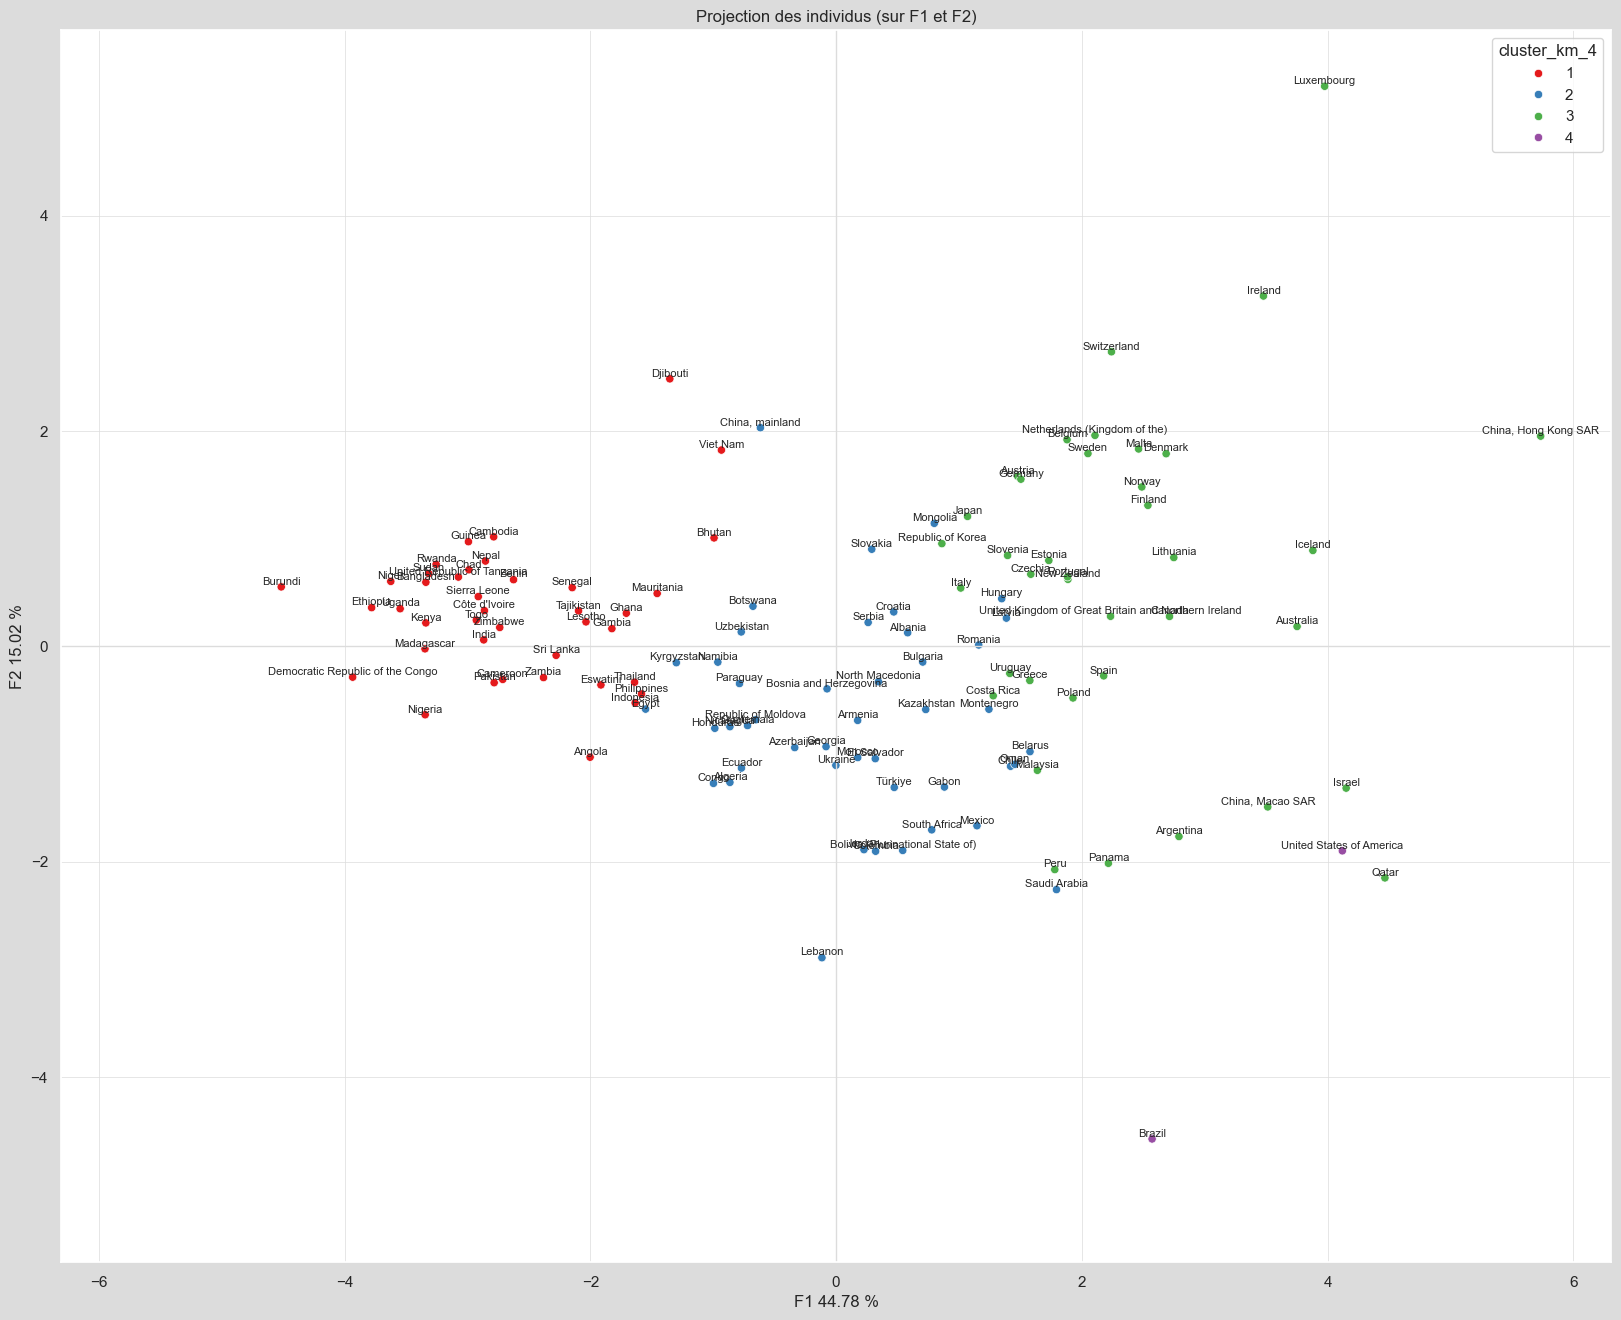

In [62]:
# plot country names on 1st factorial plane with cluster hue
x_y = (0,1)
display_factorial_planes(x_proj, x_y, pca, labels=countries, figsize=(20,16), clusters=clusters['cluster_km_4'],
                         marker="o")

#### Les pays ayant l'inertie la plus faible dans chaque cluster sont les plus proches du centroide ; on les appelle les parangons. On peut utiliser ces pays pour decrire les caracteristiques moyennes du cluster auxquel ils appartiennent.

In [65]:
# create dataframes to calculate & store distances from cluster points to centroids
distances = pd.DataFrame(x_scaled, columns=data.columns)
distances['country'] = countries
distances_calc = pd.merge(clusters, distances, how='left', right_on='country',left_on='country')

country_inertia = distances_calc[['country','cluster_km_4','urban_pop_%_y', 'gdp_growth_%_y', 'gdp_per_cap_US$_y', 'trade_%_gdp_y',
       'net_imports_poultry_US$_y', 'safety_stability_index_y',
       'poultry_consumption_kg_per_cap_y', 'total_protein_g_cap_day_y',
       'animal_protein_g_cap_day_y', 'poultry_protein_g_cap_day_y',
       'obesity_deaths_%_y']].copy()

country_inertia.rename(columns={'urban_pop_%_y': 'urban_pop_%', 'gdp_growth_%_y':'gdp_growth_%',
                            'gdp_per_cap_US$_y':'gdp_per_cap_US$', 'trade_%_gdp_y':'trade_%_gdp',
                            'net_imports_poultry_US$_y':'net_imports_poultry_US$',
                            'safety_stability_index_y':'safety_stability_index',
                            'poultry_consumption_kg_per_cap_y':'poultry_consumption_kg_per_cap', 
                            'total_protein_g_cap_day_y': 'total_protein_g_cap_day',
                            'animal_protein_g_cap_day_y':'animal_protein_g_cap_day',
                            'poultry_protein_g_cap_day_y':'poultry_protein_g_cap_day',
                            'obesity_deaths_%_y':'obesity_deaths_%'}, inplace=True)

In [66]:
# calculate square of distance from country to its assigned cluster's centroid
country_inertia.loc[country_inertia['cluster_km_4'] == 1, features] = ((np.subtract((country_inertia.loc[country_inertia['cluster_km_4'] == 1, features]),(centroids_km_4.iloc[0])))**2).copy()
country_inertia.loc[country_inertia['cluster_km_4'] == 2, features] = ((np.subtract((country_inertia.loc[country_inertia['cluster_km_4'] == 2, features]),(centroids_km_4.iloc[1])))**2).copy()
country_inertia.loc[country_inertia['cluster_km_4'] == 3, features] = ((np.subtract((country_inertia.loc[country_inertia['cluster_km_4'] == 3, features]),(centroids_km_4.iloc[2])))**2).copy()
country_inertia.loc[country_inertia['cluster_km_4'] == 4, features] = ((np.subtract((country_inertia.loc[country_inertia['cluster_km_4'] == 4, features]),(centroids_km_4.iloc[3])))**2).copy()

In [67]:
# typecast cluster number as string and sum all other numerical columns
country_inertia['cluster_km_4'] = country_inertia['cluster_km_4'].astype(str)
country_inertia['inertia'] = country_inertia.sum(axis=1, numeric_only=True)

# create distance dataframe with reduces number of columns & rename columns
clusters_dist = pd.merge(clusters, country_inertia, how='left', left_on='country',
                         right_on='country')[['country', 'cluster_km_4_x','inertia']]
clusters_dist.rename(columns={'cluster_km_4_x': 'cluster_km_4'}, inplace=True)

# display distances for each country in cluster 1 by decreasing order
clusters_dist_1 = clusters_dist.loc[clusters_dist['cluster_km_4'] == 1].copy()
clusters_dist_1.sort_values(by='inertia', ascending=False, inplace=True)
clusters_dist_1.to_csv('clusters_dist_1.csv', index=False, encoding='latin_1')
clusters_dist_1

country  cluster_km_4    inertia
108                             Sudan             1  22.083820
35                           Djibouti             1  18.795145
2                              Angola             1  11.292894
122                          Viet Nam             1   9.066509
12                             Bhutan             1   7.067174
82                              Niger             1   5.864431
18                            Burundi             1   5.847410
123                            Zambia             1   5.639054
33   Democratic Republic of the Congo             1   5.094164
41                           Ethiopia             1   4.747538
40                           Eswatini             1   4.573533
66                            Lesotho             1   4.445327
83                            Nigeria             1   4.335120
112                          Thailand             1   3.349947
87                           Pakistan             1   3.254189
72                         Mauritania             1   3.140921
20                           Cameroon             1   2.793083
22                               Chad             1   2.719287
19                           Cambodia             1   2.689697
107                         Sri Lanka             1   2.677818
47                              Ghana             1   2.550949
91                        Philippines             1   2.541741
69                         Madagascar             1   2.369165
98                             Rwanda             1   2.318598
44                             Gambia             1   2.304579
55                          Indonesia             1   2.211139
78                              Nepal             1   2.092787
111                        Tajikistan             1   1.921806
8                          Bangladesh             1   1.801300
118       United Republic of Tanzania             1   1.617539
11                              Benin             1   1.563003
115                            Uganda             1   1.488773
102                      Sierra Leone             1   1.445846
100                           Senegal             1   1.379767
30                      Côte d'Ivoire             1   1.169881
62                              Kenya             1   1.118235
50                             Guinea             1   1.087406
113                              Togo             1   0.947718
54                              India             1   0.807594
124                          Zimbabwe             1   0.598749

In [68]:
# display distances for each country in cluster 2 by decreasing order
clusters_dist_2 = clusters_dist.loc[clusters_dist['cluster_km_4'] == 2].copy()
clusters_dist_2.sort_values(by='inertia', ascending=False, inplace=True)
clusters_dist_2.to_csv('clusters_dist_2.csv', index=False, encoding='latin_1')
clusters_dist_2

country  cluster_km_4    inertia
37                              Egypt             2  31.980335
26                    China, mainland             2  28.522481
65                            Lebanon             2  27.132273
60                             Jordan             2  22.042947
28                              Congo             2  21.559564
1                             Algeria             2  20.730918
63                         Kyrgyzstan             2  18.479740
99                       Saudi Arabia             2  18.193715
121                        Uzbekistan             2  17.550013
81                          Nicaragua             2  16.006318
77                            Namibia             2  15.892433
51                           Honduras             2  15.809017
36                            Ecuador             2  15.184514
7                          Azerbaijan             2  14.831441
15                           Botswana             2  14.705181
49                          Guatemala             2  14.448855
96                Republic of Moldova             2  14.246522
114                           Türkiye             2  14.216639
116                           Ukraine             2  13.785887
89                           Paraguay             2  13.591389
27                           Colombia             2  13.585660
13   Bolivia (Plurinational State of)             2  12.779810
73                             Mexico             2  12.668990
45                            Georgia             2  12.367538
76                            Morocco             2  11.541991
105                      South Africa             2  11.133682
14             Bosnia and Herzegovina             2  11.048116
74                           Mongolia             2  10.268995
4                             Armenia             2  10.210378
84                    North Macedonia             2  10.180061
103                          Slovakia             2   9.939827
86                               Oman             2   9.845316
38                        El Salvador             2   9.123591
17                           Bulgaria             2   8.656339
43                              Gabon             2   8.615636
101                            Serbia             2   8.532949
75                         Montenegro             2   8.481344
61                         Kazakhstan             2   8.422247
9                             Belarus             2   7.920502
0                             Albania             2   7.318048
31                            Croatia             2   6.744367
97                            Romania             2   5.921477
23                              Chile             2   5.223157
52                            Hungary             2   5.067091
64                             Latvia             2   3.805917

In [69]:
# display distances for each country in cluster 3 by decreasing order
clusters_dist_3 = clusters_dist.loc[clusters_dist['cluster_km_4'] == 3].copy()
clusters_dist_3.sort_values(by='inertia', ascending=False, inplace=True)
clusters_dist_3.to_csv('clusters_dist_3.csv', index=False, encoding='latin_1')
clusters_dist_3

country  cluster_km_4  \
68                                             Luxembourg             3   
24                                   China, Hong Kong SAR             3   
59                                                  Japan             3   
56                                                Ireland             3   
25                                       China, Macao SAR             3   
110                                           Switzerland             3   
71                                                  Malta             3   
46                                                Germany             3   
39                                                Estonia             3   
109                                                Sweden             3   
95                                      Republic of Korea             3   
117  United Kingdom of Great Britain and Northern Ireland             3   
32                                                Czechia             3   
6                                                 Austria             3   
10                                                Belgium             3   
85                                                 Norway             3   
94                                                  Qatar             3   
104                                              Slovenia             3   
34                                                Denmark             3   
67                                              Lithuania             3   
120                                               Uruguay             3   
42                                                Finland             3   
53                                                Iceland             3   
93                                               Portugal             3   
80                                            New Zealand             3   
58                                                  Italy             3   
21                                                 Canada             3   
29                                             Costa Rica             3   
70                                               Malaysia             3   
57                                                 Israel             3   
48                                                 Greece             3   
90                                                   Peru             3   
5                                               Australia             3   
88                                                 Panama             3   
79                           Netherlands (Kingdom of the)             3   
106                                                 Spain             3   
3                                               Argentina             3   
92                                                 Poland             3   

        inertia  
68   106.930471  
24    93.204034  
59    77.243243  
56    71.014689  
25    68.920426  
110   65.975715  
71    65.273407  
46    59.648952  
39    57.592902  
109   57.543787  
95    57.253832  
117   56.250093  
32    56.101525  
6     55.652436  
10    54.944338  
85    54.859577  
94    54.557352  
104   53.090364  
34    52.754424  
67    52.670561  
120   51.791999  
42    51.530742  
53    51.280254  
93    50.843377  
80    50.416032  
58    49.476413  
21    48.460486  
29    48.331539  
70    48.072152  
57    47.355251  
48    46.878662  
90    46.392256  
5     45.130793  
88    45.010382  
79    42.936043  
106   41.709439  
3     38.442222  
92    23.078112

In [70]:
# display distances for each country in cluster 4 by decreasing order
clusters_dist_4 = clusters_dist.loc[clusters_dist['cluster_km_4'] == 4].copy()
clusters_dist_4.sort_values(by='inertia', ascending=False, inplace=True)
clusters_dist_4.to_csv('clusters_dist_4.csv', index=False, encoding='latin_1')
clusters_dist_4

country  cluster_km_4    inertia
16                     Brazil             4  73.315093
119  United States of America             4  44.765060

#### Les parangons sont ici respectivement le Salvador pour le cluster 1, le Zimbabwe pour le cluster 2 et le Danemark pour le cluster 3. Le cluster 4 quant a lui ne comporte que 2 pays qui sont donc par definition tous les deux des parangons: bien que differant ici considerablement du point de vue des donnees macro-economiques, alimentaires et demographiques, le Bresil et les USA sont rassembles par leur grande proximite sur le plan des imports nets de poulet (tres negatifs, signalant des export nets tres importants) et qui les mettent donc tres a part des autres pays malgre leurs differences sur d'autres plans (maximisation de la variance inter-clusters malgre leur variance intra-cluster).
#### D'apres les chiffres de l'industrie (ANVOL 2021), les USA et le Bresil sont les deux plus grands exportateurs mondiaux de poulet, devant l'UE. Si l'on considerait l'UE comme un seul pays pour cette analyse, il est probable qu'on la retrouverait dans le meme cluster que ces 2 pays. En pratique, en Europe, ce sont la Pologne et les Pays-Bas qui sont les plus grands exportateurs nets de poulet, mais tres loin derriere les Etats-Unis et le Bresil. Les pays de l'UE ayant par ailleurs bien plus de similarites entre eux, au plan economique notamment, ils se retrouvent donc dans le meme cluster (minimisation de la variance intra-clusters).
#### La fragmentation de l'UE a 27 en autant de pays dans cette analyse nous permet par ailleurs de conserver une granularite necessaire pour affiner les recommandations strategiques.

### Verification des calculs de distance

In [71]:
if (round(country_inertia['inertia'].sum(),3) - round(kmeans_4.inertia_,3)) != 0:
    print("Calculation issue.")
else:
    print("Calculation OK.")

Calculation issue.


In [72]:
# note - there are only 2 data points in cluster 4, so they should be equidistant from the centroid
clusters_dist_4 = clusters_dist.loc[clusters_dist['cluster_km_4'] == 4].copy()
clusters_dist_4.sort_values(by='inertia', ascending=False, inplace=True)
clusters_dist_4

country  cluster_km_4    inertia
16                     Brazil             4  73.315093
119  United States of America             4  44.765060

#### Comme il n'y a que 2 points dans le cluster 4, on verifie bien qu'ils sont equidistants du centroide, ce qui est egalement verifiable graphiquement sur leur projection sur le premeir plan factoriel.